In [1]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [2]:
!pip install opencv-python 

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm
from itertools import chain
 
from skimage.io import imread, imshow
import random
import cv2
# tf.enable_eager_execution()

In [5]:
%matplotlib inline

In [6]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
DATA_PATH = 'stage1_train/'

In [7]:
ROOT_DIR = os.path.abspath(os.curdir)
print(ROOT_DIR)

E:\PracticePojects\DataScience\Deep Learning


In [8]:
# for root, folders, files in os.walk(ROOT_DIR):
#     print(root)
#     for filename in files:
#         print (filename)

In [9]:
seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[1]
 
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
 
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = DATA_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
 
x_train=X
 
y_train=Y

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:39<00:00,  6.71it/s]


In [10]:
counter = 0
for x, y in tqdm(enumerate(image_ids), total=len(image_ids)):
    counter +=1
    print(x, y)
    if(counter>=3):
        break

  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

0 00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
1 003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
2 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]


In [11]:
# for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
#     print(id_)

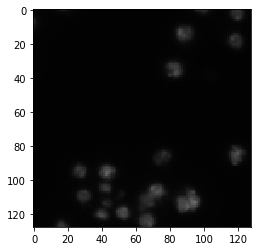

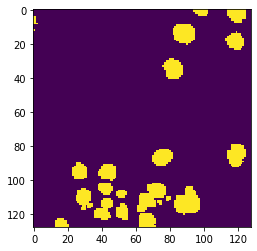

In [12]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(np.squeeze(y_train[0]))
plt.show()

# np.squeeze(y_train[0])

In [13]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 16) 4624        concatenate_3[0][0]              
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 128, 128, 16) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 16) 2320        dropout_8[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 1)  17          conv2d_17[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [14]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#   tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=20,
                    callbacks=callbacks)
 

Train on 603 samples, validate on 67 samples
Epoch 1/20
592/603 [============================>.] - ETA: 16:05 - loss: 0.6570 - accuracy: 0.599 - ETA: 7:58 - loss: 0.6452 - accuracy: 0.683 - ETA: 5:15 - loss: 0.6215 - accuracy: 0.72 - ETA: 3:53 - loss: 0.5865 - accuracy: 0.75 - ETA: 3:04 - loss: 0.5625 - accuracy: 0.77 - ETA: 2:31 - loss: 0.5457 - accuracy: 0.77 - ETA: 2:07 - loss: 0.5594 - accuracy: 0.76 - ETA: 1:49 - loss: 0.5447 - accuracy: 0.76 - ETA: 1:35 - loss: 0.5245 - accuracy: 0.77 - ETA: 1:24 - loss: 0.5137 - accuracy: 0.78 - ETA: 1:15 - loss: 0.5082 - accuracy: 0.78 - ETA: 1:07 - loss: 0.4988 - accuracy: 0.79 - ETA: 1:00 - loss: 0.4865 - accuracy: 0.79 - ETA: 54s - loss: 0.4760 - accuracy: 0.8007 - ETA: 49s - loss: 0.4606 - accuracy: 0.807 - ETA: 45s - loss: 0.4473 - accuracy: 0.813 - ETA: 41s - loss: 0.4397 - accuracy: 0.814 - ETA: 37s - loss: 0.4272 - accuracy: 0.820 - ETA: 34s - loss: 0.4156 - accuracy: 0.825 - ETA: 31s - loss: 0.4057 - accuracy: 0.829 - ETA: 28s - loss: 

592/603 [============================>.] - ETA: 17s - loss: 0.0979 - accuracy: 0.963 - ETA: 16s - loss: 0.1004 - accuracy: 0.961 - ETA: 16s - loss: 0.1237 - accuracy: 0.953 - ETA: 15s - loss: 0.1269 - accuracy: 0.952 - ETA: 15s - loss: 0.1289 - accuracy: 0.951 - ETA: 14s - loss: 0.1203 - accuracy: 0.954 - ETA: 14s - loss: 0.1209 - accuracy: 0.953 - ETA: 13s - loss: 0.1160 - accuracy: 0.955 - ETA: 13s - loss: 0.1240 - accuracy: 0.949 - ETA: 13s - loss: 0.1265 - accuracy: 0.949 - ETA: 12s - loss: 0.1231 - accuracy: 0.950 - ETA: 12s - loss: 0.1214 - accuracy: 0.951 - ETA: 11s - loss: 0.1201 - accuracy: 0.952 - ETA: 11s - loss: 0.1229 - accuracy: 0.951 - ETA: 10s - loss: 0.1237 - accuracy: 0.951 - ETA: 10s - loss: 0.1233 - accuracy: 0.951 - ETA: 9s - loss: 0.1238 - accuracy: 0.951 - ETA: 9s - loss: 0.1225 - accuracy: 0.95 - ETA: 8s - loss: 0.1215 - accuracy: 0.95 - ETA: 8s - loss: 0.1196 - accuracy: 0.95 - ETA: 7s - loss: 0.1202 - accuracy: 0.95 - ETA: 7s - loss: 0.1184 - accuracy: 0.95 - 

592/603 [============================>.] - ETA: 17s - loss: 0.0860 - accuracy: 0.969 - ETA: 16s - loss: 0.0987 - accuracy: 0.963 - ETA: 16s - loss: 0.0861 - accuracy: 0.967 - ETA: 15s - loss: 0.0846 - accuracy: 0.968 - ETA: 15s - loss: 0.0841 - accuracy: 0.968 - ETA: 14s - loss: 0.0823 - accuracy: 0.969 - ETA: 14s - loss: 0.0858 - accuracy: 0.967 - ETA: 13s - loss: 0.0941 - accuracy: 0.964 - ETA: 13s - loss: 0.0948 - accuracy: 0.964 - ETA: 13s - loss: 0.0947 - accuracy: 0.964 - ETA: 12s - loss: 0.0905 - accuracy: 0.966 - ETA: 12s - loss: 0.0918 - accuracy: 0.965 - ETA: 11s - loss: 0.0931 - accuracy: 0.964 - ETA: 11s - loss: 0.0925 - accuracy: 0.965 - ETA: 10s - loss: 0.0923 - accuracy: 0.965 - ETA: 10s - loss: 0.0932 - accuracy: 0.964 - ETA: 9s - loss: 0.0911 - accuracy: 0.965 - ETA: 9s - loss: 0.0910 - accuracy: 0.96 - ETA: 8s - loss: 0.0907 - accuracy: 0.96 - ETA: 8s - loss: 0.0906 - accuracy: 0.96 - ETA: 7s - loss: 0.0902 - accuracy: 0.96 - ETA: 7s - loss: 0.0907 - accuracy: 0.96 - 

1/1 [==============================] - 2s 2s/sample


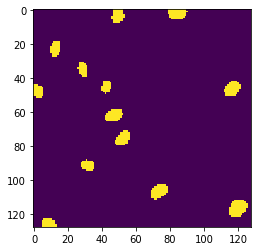

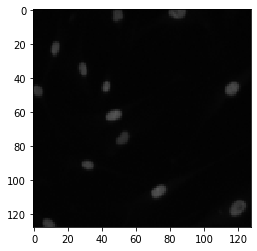

In [15]:
idx = random.randint(0, len(x_train))
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
plt.imshow(np.squeeze(predict[0]))
plt.show()
 
plt.imshow(x_train[idx])
 
plt.show()